**извлечение признаков из текста на естественном языке**

классификатор текстов

частотный анализ с очисткой стоп-слов (TF)

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [29]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

/usr/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
sklearn.__version__

'0.23.2'

## тексты

In [4]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))

записей: 3196


In [5]:
data.sample(2)

,text,tag
3165,"VSESMI.RU - Политика Закон об охоте, учитывающий интересы коренных\nмалочисленных народов Севера, вступит в силу с 1 января 2011 года Проект\nфедерального закона ?О внесении изменений в Федеральны...",politics
1448,"Мехико, 13 декабря. Глава правительства Венесуэлы Николас Мадуро по итогам переговоров с ведущими экономическими советниками принял решение закрыть границу с Колумбией на 72 часа. На такой шаг ему...",politics


## токенизация и очистка

In [6]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def text_normalizer(s):
    pat = [
        [r'[ієјѕµ_]',' '] # мусор
       ,[r'ё','е'] # замена ё для унификации
       ,[r'[a-zа-я-]*\d+[a-zа-я-]*\d*',' '] # коды
       ,[r'\b\d+\b',' '] # цифры
       ,[r'\W',' '] # спец.символы
       ,[r'\b[a-zа-я]\b',' '] # отдельные символы
       ,[r' +',' '] # повторы пробелов
    ]
    
    return replace_patterns(s.lower(),pat).strip()

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# from nltk import download as nltk_download
# nltk_download('stopwords')

stopwords = set(nltk_stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenize(s): 
    return [ stemmer.stem(w) for w in s.split() if w not in stopwords ]


In [7]:
data['ctext'] = data['text'].progress_apply(text_normalizer)
data['ctext'] = data['ctext'].progress_apply( tokenize )
data['ctext'] = data['ctext'].progress_apply( ' '.join  )

100%|██████████| 3196/3196 [00:00<00:00, 205472.04it/s]


##  CountVectorizer + TF

In [8]:
# TfidfVectorizer(*, 
#                 input='content', 
#                 encoding='utf-8', 
#                 decode_error='strict',
#                 strip_accents=None, 
#                 lowercase=True, 
#                 preprocessor=None, 
#                 tokenizer=None,
#                 analyzer='word', 
#                 stop_words=None, 
#                 token_pattern='(?u)\b\w\w+\b', 
#                 ngram_range=(1, 1), 
#                 max_df=1.0, 
#                 min_df=1, 
#                 max_features=None, 
#                 vocabulary=None, 
#                 binary=False, 
#                 dtype=<class 'numpy.float64'>, 
#                 norm='l2', 
#                 use_idf=True, 
#                 smooth_idf=True, 
#                 sublinear_tf=False
#                )

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(use_idf=True, norm='l2')\
        .fit( data['ctext'] )

print(len(tf.vocabulary_))

34799


In [10]:
# pd.DataFrame( sorted(tf.vocabulary_) ).to_csv('voc.txt',index=False,header=False)

## формируем датасеты

In [11]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 34799)

In [12]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [13]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

---

In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.9, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((319, 34799), (319,), (2877, 34799), (2877,))

## обучаем классификатор

In [15]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [16]:
o = clf.predict(X_train)

In [17]:
accuracy_score(y_train,o)

1.0

In [18]:
o = clf.predict(X_test)

In [19]:
accuracy_score(y_test,o)

0.7751129648939868

In [20]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       227
           1       0.75      0.82      0.79       319
           2       0.86      0.70      0.77       240
           3       0.44      0.17      0.25        86
           4       0.83      0.84      0.83       396
           5       0.74      0.91      0.81       542
           6       0.66      0.36      0.47        58
           7       0.54      0.51      0.53        41
           8       0.72      0.98      0.83       200
           9       0.52      0.27      0.36       133
          10       0.85      0.96      0.91       340
          11       0.83      0.66      0.73       262
          12       0.42      0.42      0.42        33

    accuracy                           0.78      2877
   macro avg       0.70      0.64      0.66      2877
weighted avg       0.77      0.78      0.76      2877



---

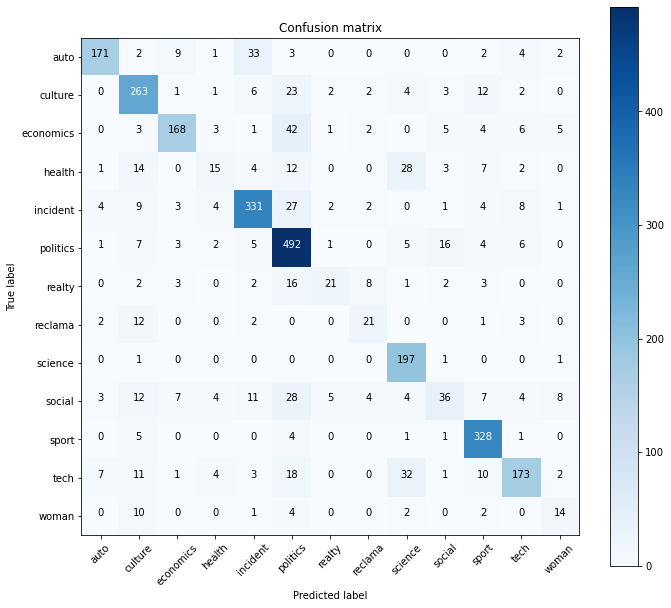

In [21]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [22]:
o = clf.predict(X)

In [23]:
labels_inv = { labels[k]:k for k in labels }
# labels_inv

In [42]:
for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: politics
predict: politics
Выборщик-республиканец из Техаса отказался голосовать за Трампа 6 декабря 2016 в 7:06 Русская служба Би-би-си Член коллегии выборщиков от штата Техас Крис Супрун, представляющий Республиканскую пар...
- - - - - - - - - - - - - - - - - -
tag: culture
predict: culture
ИА Regnum В Хабаровске пройдет фестиваль художественных ремесел коренных
народов В Хабаровске с 12 по 16 августа в рамках Второго Международного
десятилетия коренных народов мира пройдет II Дальневост...
- - - - - - - - - - - - - - - - - -
tag: culture
predict: politics
Симферопольские битломаны почтут память Джона Леннона Сегодня исполняется
25 лет с момента убийства лидера квартета The Beatles Джона Леннона. В
Симферополе фанаты легендарного музыканта решили почтит...
- - - - - - - - - - - - - - - - - -
tag: incident
predict: incident
Второй раз за неделю: в Могилеве во время движения загорелся рейсовый автобус 9 декабря 2016 в 11:32 AUTO.TUT.BY В Могилеве во время движения снова загорелся 

In [ ]:
# https://habr.com/ru/post/205360/